In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE
import nltk.data

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [2]:
# read the dataset
fileLocation = r"C:\Users\user\Documents\UoM\Thesis\data\Clothing_Shoes_and_Jewelry_5.json"
reviews_data = pd.read_json(fileLocation, lines=True)

# Keep only the review text and the grade
reviews_data = reviews_data[['overall', 'reviewText']]

# Drop the products whose values are null
reviews_data = reviews_data[reviews_data['reviewText'].notna()]

ratings = []
for index,entry in enumerate(reviews_data['overall']):
    if entry == 1.0 or entry == 2.0:
        ratings.append(-1)
    elif entry == 3.0:
        ratings.append(0)
    elif entry == 4.0 or entry == 5.0:
        ratings.append(1)

In [3]:
""""
Split each review into sentences
and preprocess each sentence
"""
sentenceEnders = re.compile('[.!?]')

stopwords = stopwords.words('english')
stopwords.remove('not')
stopwords.extend(['wear', 'shoes', 'size', 'fit', 'look', 'good'])

preprocessed_data = []
index = 0
for review in reviews_data['reviewText']: 
    review_sentences = sentenceEnders.split(review)
    for sentence in review_sentences:
        sentence = re.sub(r'not a *', 'not',sentence)
        sentence = re.sub(r'not *', 'not',sentence) 
        sentence = re.sub(r"\w+n't ", 'not',sentence) 
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        sentence = sentence.lower()
        sentence = word_tokenize(sentence)
        sentence = [word for word in sentence if not word in stopwords]
        sentence = ' '.join(sentence)
        if(sentence != ''):
            review = {}
            review["index"] = index
            review["sentence"] = sentence
            review["rating"] = ratings[index]
            preprocessed_data.append(review)
    index+=1

In [4]:
print("Before preprocessing: ", reviews_data['reviewText'][7])
print("------------------------------------------------")
print("After preprocessing: ", [d for d in preprocessed_data if d['index'] == 7])
print(len(preprocessed_data))

Before preprocessing:  Great tutu for a great price. It isn't a &#34;full&#34; or high quality skirt, but it is perfect for my daughter to wear over leggings for her little outfits.
------------------------------------------------
After preprocessing:  [{'index': 7, 'sentence': 'great tutu great price', 'rating': 1}, {'index': 7, 'sentence': 'nota full high quality skirt perfect daughter leggings little outfits', 'rating': 1}]
1305851


In [5]:
# Split Dataset into training and test
indexes = [i for i in range(len(reviews_data))]

Train_X_index, Test_X_index, Train_Y_review, Test_Y_review = model_selection.train_test_split(indexes,ratings,test_size=0.3, random_state=42)

df = pd.DataFrame(preprocessed_data)

train = df[df['index'].isin(Train_X_index)]
Train_Y = train['rating'].tolist()
Train_X = train['sentence'].tolist()
Train_index = train['index'].tolist()


test = df[df['index'].isin(Test_X_index)]
Test_Y = test['rating'].tolist()
Test_X = test['sentence'].tolist()
Test_index = test['index'].tolist()

all_sentences = Train_X + Test_X

In [6]:
len(df)

1305851

In [7]:
# Word Vectorization   
TfIdf_vect = TfidfVectorizer(max_features=10000)
TfIdf_vect.fit(all_sentences)
Train_X_TfIdf = TfIdf_vect.transform(Train_X)
Test_X_TfIdf = TfIdf_vect.transform(Test_X)

In [8]:
# Oversampling 
oversample = SMOTE(random_state=100)
X_SMOTE, y_SMOTE = oversample.fit_resample(Train_X_TfIdf, Train_Y)

In [9]:
def find_Max_Element(scores):
    c = Counter(scores)
    negatives = c[-1]
    neutral = c[0]
    positives = c[1]
    
    if(scores[0] == -1):
        negatives += 1
    elif(scores[0] == 0):
        neutral += 1
    elif(scores[0] == 1):
        positives += 1
    
    if(scores[-1] == -1):
        negatives += 1
    elif(scores[-1] == 0):
        neutral += 1
    elif(scores[-1] == 1):
        positives += 1

    if(neutral == positives and neutral > negatives and positives > negatives):
        max_element = 1
    elif (neutral == negatives and neutral > positives and negatives > positives):
        max_element = -1
    elif (neutral == negatives and negatives == positives):
        max_element = 0
    elif (positives == negatives and positives > neutral and negatives > neutral) :
        max_element = 0
    else:
        max_element = max(set(scores), key = scores.count)
        
    return max_element


Accuracy:  75.11933102846
--------------------------
              precision    recall  f1-score   support

    Negative       0.50      0.60      0.55      7996
     Neutral       0.26      0.47      0.33      9177
    Positive       0.94      0.81      0.87     66418

    accuracy                           0.75     83591
   macro avg       0.56      0.63      0.58     83591
weighted avg       0.82      0.75      0.78     83591



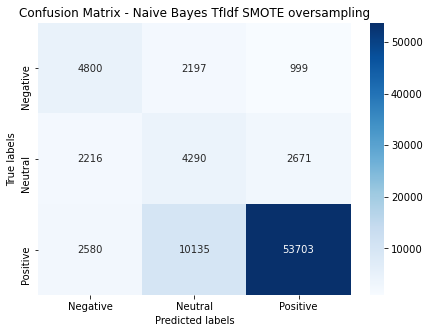

In [10]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_SMOTE, y_SMOTE)

# predict the labels on validation dataset
predictions_NB_sentences = Naive.predict(Test_X_TfIdf)

# Get grades by review
predicted_scores_frame = pd.DataFrame(np.column_stack([Test_index, predictions_NB_sentences, Test_Y]), 
                               columns=['review Index', 'prediction', 'actual'])

# print(len(predicted_scores_frame['review Index'].unique()) - len(Test_Y_review))

# for each review get all scores by review
scores_by_review_frame = predicted_scores_frame.groupby('review Index')['prediction'].apply(list)
majority_scores =  scores_by_review_frame.apply(find_Max_Element)
predicted_scores = list(majority_scores)

# for each review get its actual score
actual_scores_frame = predicted_scores_frame.groupby('review Index')['actual'].first()
actual_scores = list(actual_scores_frame)

# get all indexes
review_indexes = predicted_scores_frame['review Index'].unique()

# Calculate Accuracy
accuracy = accuracy_score(predicted_scores, actual_scores)*100
print("Accuracy: ", accuracy)
print("--------------------------")

# Confusion Matrix
cm = confusion_matrix(actual_scores, predicted_scores)
plt.figure(figsize = (7,5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',ax=ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Naive Bayes TfIdf SMOTE oversampling'); 
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']);

# Classification Report
my_tags = ['Negative','Neutral','Positive']
print(classification_report(actual_scores, predicted_scores, target_names=my_tags))
report = classification_report(actual_scores, predicted_scores, target_names=my_tags, output_dict=True);
clsf_report = pd.DataFrame(report).transpose()
clsf_report.to_csv('reports/NaiveBayes_TfIdf_Oversampling.csv', index= True)

In [11]:
# write indexes of false classified reviews to a txt file

data = {"review_index": review_indexes, "predict": predicted_scores, "actual": actual_scores}

review_dataframe = pd.DataFrame(data)

false_classified_indexes = review_dataframe['review_index'][review_dataframe['predict'] != review_dataframe['actual']]
false_classified_indexes = list(false_classified_indexes)

with open("indexes/NaiveBayes_TfIdf_Oversampling.txt", 'w') as f:
    for item in false_classified_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as negative but they are neutral
negativePredicted_neutralActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == -1) & (review_dataframe['actual'] == 0)]
negativePredicted_neutralActual_indexes = list(negativePredicted_neutralActual_indexes)
with open("indexes/NaiveBayes_TfIdf_Oversampling_NegativePredicted_NeutralActual.txt", 'w') as f:
    for item in negativePredicted_neutralActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as negative but they are positive
negativePredicted_positiveActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == -1) & (review_dataframe['actual'] == 1)]
negativePredicted_positiveActual_indexes = list(negativePredicted_positiveActual_indexes)
with open("indexes/NaiveBayes_TfIdf_Oversampling_NegativePredicted_PositiveActual.txt", 'w') as f:
    for item in negativePredicted_positiveActual_indexes:
        f.write("%s\n" % item)
        
# save those indexes who are predicted as neutral but they are negative
neutralPredicted_negativeActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == 0) & (review_dataframe['actual'] == -1)]
neutralPredicted_negativeActual_indexes = list(neutralPredicted_negativeActual_indexes)
with open("indexes/NaiveBayes_TfIdf_Oversampling_NeutralPredicted_NegativeActual.txt", 'w') as f:
    for item in neutralPredicted_negativeActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as neutral but they are positive
neutralPredicted_positiveActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == 0) & (review_dataframe['actual'] == 1)]
neutralPredicted_positiveActual_indexes = list(neutralPredicted_positiveActual_indexes)
with open("indexes/NaiveBayes_TfIdf_Oversampling_NeutralPredicted_PositiveActual.txt", 'w') as f:
    for item in neutralPredicted_positiveActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as positive but they are negative        
positivePredicted_negativeActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == 1) & (review_dataframe['actual'] == -1)]
positivePredicted_negativeActual_indexes = list(positivePredicted_negativeActual_indexes)
with open("indexes/NaiveBayes_TfIdf_Oversampling_PositivePredicted_NegativeActual.txt", 'w') as f:
    for item in positivePredicted_negativeActual_indexes:
        f.write("%s\n" % item)
 
# save those indexes who are predicted as positive but they are neutral 
positivePredicted_neutralActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == 1) & (review_dataframe['actual'] == 0)]
positivePredicted_neutralActual_indexes = list(positivePredicted_neutralActual_indexes)
with open("indexes/NaiveBayes_TfIdf_Oversampling_PositivePredicted_NeutralActual.txt", 'w') as f:
    for item in positivePredicted_neutralActual_indexes:
        f.write("%s\n" % item)